In [3]:
import os
import numpy as np
import pandas as pd
# Plot the data for visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageChops, ImageEnhance
from io import BytesIO
from multiprocessing import Pool
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split, StratifiedKFold
# Evaluate the model performance
from sklearn.metrics import (
    classification_report,
# Generate the confusion matrix for predictions
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
# Calculate the ROC curve and AUC (Area Under the Curve) for performance metrics
    roc_curve,
# Calculate the ROC curve and AUC (Area Under the Curve) for performance metrics
    auc,
)
from sklearn.neighbors import KNeighborsClassifier
# Perform dimensionality reduction using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot
import torch
import torch.nn as nn
# Define the model architecture in PyTorch
import torchvision.models as models_torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
# Log relevant messages for debugging and tracking
import logging
import seaborn as sns

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Log relevant messages for debugging and tracking
# Set up logging
# Log relevant messages for debugging and tracking
logging.basicConfig(level=logging.INFO)
# Log relevant messages for debugging and tracking
logger = logging.getLogger(__name__)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def adaptive_ela(image_path, quality=90):
    original = Image.open(image_path).convert('RGB')
    buffer = BytesIO()
    original.save(buffer, 'JPEG', quality=quality)
    buffer.seek(0)
    resaved = Image.open(buffer)
    ela_image = ImageChops.difference(original, resaved)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return np.array(ela_image)

def adaptive_ela_and_resize(path):
    ela_img = adaptive_ela(path)
# Resize images using OpenCV to standardize input dimensions
    ela_img = cv2.resize(ela_img, (224, 224))
    return ela_img

# Process images for training using multiprocessing
def preprocess_images(image_paths):
    with Pool() as pool:
        images = pool.map(adaptive_ela_and_resize, image_paths)
    return np.array(images)

In [7]:
real_images_path = '/content/drive/MyDrive/CS570_Deep_Learning/real_and_fake_face/training_real/'
fake_images_path = '/content/drive/MyDrive/CS570_Deep_Learning/real_and_fake_face/training_fake/'
# real_images_path = 'real_and_fake_face/training_real/'
# fake_images_path = 'real_and_fake_face/training_fake/'

real_images = [os.path.join(real_images_path, img) for img in os.listdir(real_images_path)]
fake_images = [os.path.join(fake_images_path, img) for img in os.listdir(fake_images_path)]
all_images = real_images + fake_images
labels = [0] * len(real_images) + [1] * len(fake_images)

data = pd.DataFrame({'image_path': all_images, 'label': labels})
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess images
X = preprocess_images(data['image_path'])
y = np.array(data['label'])

# Train-Test Split
# Split the data into training and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15 / 0.85, random_state=42, stratify=y_temp
)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)


In [8]:
def create_efficientnet_model():
    base_model = EfficientNetB0(
        weights='imagenet', include_top=False, input_shape=(224, 224, 3)
    )
    # Unfreeze some layers for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
# Evaluate the model performance
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

efficientnet_model = create_efficientnet_model()

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/CS570_Deep_Learning/best_efficientnet_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the EfficientNet model
# Train the model using the training data and validate using the validation set
history = efficientnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[early_stopping, lr_reduction, checkpoint],
)

# Load the best model
efficientnet_model.load_weights('/content/drive/MyDrive/CS570_Deep_Learning/best_efficientnet_model.keras')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5017 - loss: 0.7208 - val_accuracy: 0.5752 - val_loss: 0.6845 - learning_rate: 1.0000e-04
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 365ms/step - accuracy: 0.5629 - loss: 0.6814 - val_accuracy: 0.6209 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.6288 - loss: 0.6462 - val_accuracy: 0.6340 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - accuracy: 0.6637 - loss: 0.6327 - val_accuracy: 0.6471 - val_loss: 0.6309 - learning_rate: 1.0000e-04
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - accuracy: 0.6963 - loss: 0.5813 - val_accuracy: 0.6601 - val_loss: 0.6257 - learning_rate: 1.0000e-04
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.7246 - loss: 0.5528 - val_accuracy: 0.6667 - val_loss: 0.6601 - learning_rate: 1.0000e-04
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 338ms/step - accuracy: 0.7582

In [9]:
# Train a K-Nearest Neighbors (KNN) classifier
def prepare_data_for_knn(X_train, X_val, X_test):
    scaler = StandardScaler()
# Perform dimensionality reduction using PCA
    pca = PCA(n_components=200)  # Adjust components as needed

    # Flatten the images
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Perform dimensionality reduction using PCA
    # Standardize and apply PCA
    X_train_scaled = scaler.fit_transform(X_train_flat)
# Perform dimensionality reduction using PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_scaled = scaler.transform(X_val_flat)
# Perform dimensionality reduction using PCA
    X_val_pca = pca.transform(X_val_scaled)
    X_test_scaled = scaler.transform(X_test_flat)
# Perform dimensionality reduction using PCA
    X_test_pca = pca.transform(X_test_scaled)

# Perform dimensionality reduction using PCA
    return X_train_pca, X_val_pca, X_test_pca, scaler, pca

# Perform dimensionality reduction using PCA
X_train_pca, X_val_pca, X_test_pca, scaler, pca = prepare_data_for_knn(X_train, X_val, X_test)

# Train a K-Nearest Neighbors (KNN) classifier
# Train KNN with reduced data
# Train a K-Nearest Neighbors (KNN) classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
# Perform dimensionality reduction using PCA
knn_clf.fit(X_train_pca, y_train)

KNeighborsClassifier()

In [10]:
def create_vit_model():
# Define the model architecture in PyTorch
    vit_model = models_torch.vit_b_16(weights='IMAGENET1K_V1')
    vit_model.heads = nn.Sequential(
        nn.Linear(vit_model.heads.head.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 1),
    )
    return vit_model

# Prepare datasets for ViT
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # numpy arrays
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img_pil = Image.fromarray(img.astype('uint8'), 'RGB')
        if self.transform:
            img = self.transform(img_pil)
        else:
            img = transforms.ToTensor()(img_pil)
        label = self.labels[idx]
        return img, label

train_dataset = ImageDataset(X_train, y_train, transform=vit_transform)
val_dataset = ImageDataset(X_val, y_val, transform=vit_transform)
test_dataset = ImageDataset(X_test, y_test, transform=vit_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train ViT Model
vit_model = create_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

criterion = nn.BCEWithLogitsLoss()
# Define the model architecture in PyTorch
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Validation
    vit_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = vit_model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    logger.info(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
# Define the model architecture in PyTorch
        torch.save(vit_model.state_dict(), '/content/drive/MyDrive/CS570_Deep_Learning/best_vit_model.pth')

# Load the best ViT model
# Define the model architecture in PyTorch
vit_model.load_state_dict(torch.load('/content/drive/MyDrive/CS570_Deep_Learning/best_vit_model.pth'))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 50.1MB/s]
<ipython-input-10-e0ed3c8cedf1>:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

<All keys matched successfully>

In [11]:
# Perform dimensionality reduction using PCA
def ensemble_predict_batch(efficientnet_model, vit_model, knn_clf, scaler, pca, X_data, batch_size=64, device='cpu'):
    final_predictions = []
    vit_model.eval()
    vit_model.to(device)

    vit_transform_eval = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    for i in range(0, len(X_data), batch_size):
        # Process a batch of data
        X_batch = X_data[i:i + batch_size]

        # EfficientNet predictions
        eff_pred = efficientnet_model.predict(X_batch)
        eff_pred_class = (eff_pred > 0.5).astype(int).flatten()

        # Prepare data for ViT
        X_batch_vit = []
        for img in X_batch:
            img_pil = Image.fromarray(img.astype('uint8'), 'RGB')
            img_vit = vit_transform_eval(img_pil)
            X_batch_vit.append(img_vit)
        X_batch_vit = torch.stack(X_batch_vit).to(device)

        with torch.no_grad():
            vit_pred = vit_model(X_batch_vit)
            vit_pred_probs = torch.sigmoid(vit_pred).cpu().numpy()
        vit_pred_class = (vit_pred_probs > 0.5).astype(int).flatten()

# Perform dimensionality reduction using PCA
        # Flatten and apply scaler and PCA for KNN
        X_batch_flat = X_batch.reshape(X_batch.shape[0], -1)
        X_batch_scaled = scaler.transform(X_batch_flat)
# Perform dimensionality reduction using PCA
        X_batch_pca = pca.transform(X_batch_scaled)

# Perform dimensionality reduction using PCA
        knn_pred = knn_clf.predict_proba(X_batch_pca)[:, 1]
# Train a K-Nearest Neighbors (KNN) classifier
        knn_pred_class = (knn_pred > 0.5).astype(int)

        # Final ensemble prediction: majority voting
# Train a K-Nearest Neighbors (KNN) classifier
        total_pred = eff_pred_class + vit_pred_class + knn_pred_class
        batch_pred = (total_pred >= 2).astype(int)  # Majority vote among 3 models

        final_predictions.extend(batch_pred)

    return np.array(final_predictions)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
              precision    recall  f1-score   support

           0       0.62      0.81      0.70       163
           1       0.67      0.43      0.52       144

    accuracy                           0.63       307
   macro avg       0.64      0.62      0.61       307
weighted avg       0.64      0.63      0.62       307

Confusion Matrix:
[[132  31]
 [ 82  62]]


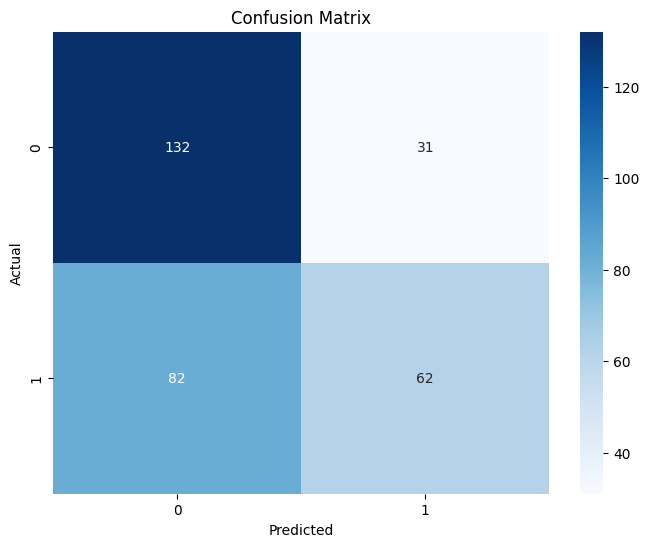

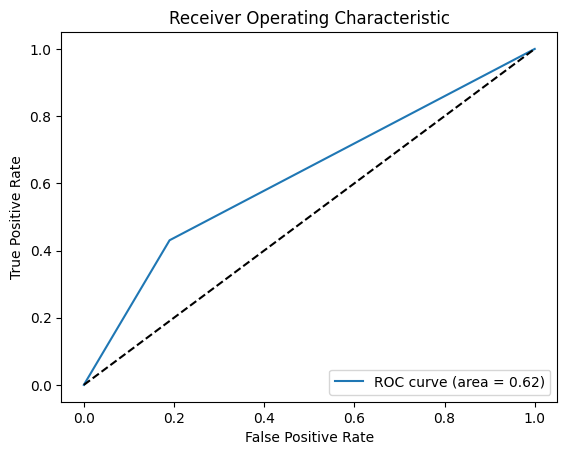

In [12]:
final_predictions = ensemble_predict_batch(
# Perform dimensionality reduction using PCA
    efficientnet_model, vit_model, knn_clf, scaler, pca, X_test, batch_size=64, device=device
)

print(classification_report(y_test, final_predictions))

# Generate the confusion matrix for predictions
conf_matrix = confusion_matrix(y_test, final_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model performance
# ROC and AUC Metrics
# Calculate the ROC curve and AUC (Area Under the Curve) for performance metrics
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)
# Calculate the ROC curve and AUC (Area Under the Curve) for performance metrics
roc_auc = auc(fpr, tpr)
plt.figure()
# Calculate the ROC curve and AUC (Area Under the Curve) for performance metrics
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
# Plot the data for visualization
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [13]:
accuracy = np.mean(final_predictions == y_test)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')


Accuracy: 0.63, Precision: 0.67, Recall: 0.43, F1-Score: 0.52


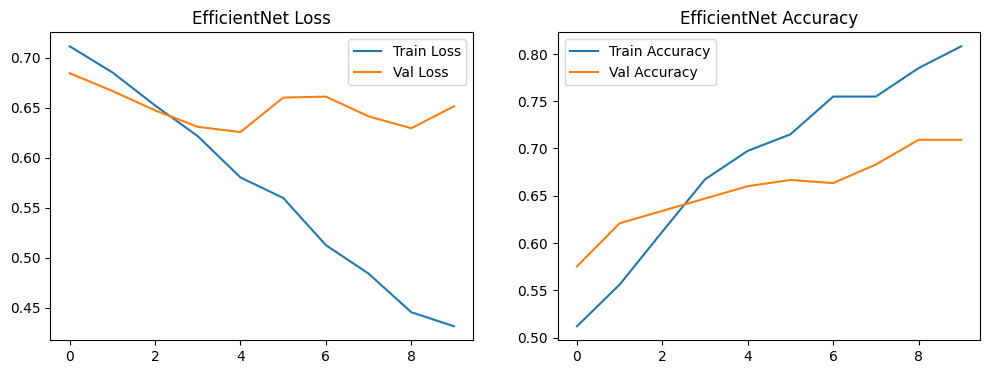

In [14]:
plt.figure(figsize=(12, 4))
# Plot the data for visualization
plt.subplot(1, 2, 1)
# Plot the data for visualization
plt.plot(history.history['loss'], label='Train Loss')
# Plot the data for visualization
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('EfficientNet Loss')
# Plot the data for visualization
plt.subplot(1, 2, 2)
# Plot the data for visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
# Plot the data for visualization
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('EfficientNet Accuracy')
plt.show()